## Installing libraries

## Importing libs

In [3]:
import requests
from scrapy import Selector
from bs4 import BeautifulSoup as bs
import pandas as pd

## Selectors

In [60]:
url = 'https://www.inovacaotecnologica.com.br/noticias/meta.php?meta=Baterias&base='

In [66]:
urls = []
for i in [0, 15, 30, 45]:
    urls.append(url+str(i))

In [6]:
baterias = requests.get(url).content

In [84]:
def colect_baterias(url):
    sel_quotes = Selector(text=quotes)
    sel
    data = sel.css('.data::text').extract()
    text = sel.css('p::text').extract()
    link = sel.xpath('//h2//@href').extract()
    title = sel.css('h2 *::text').extract()
    df = pd.DataFrame({'data': data,
                  'title':title,
                   'link':link
                  })
    return(df)

In [85]:
list_dfs = []

for i in urls:
    list_dfs.append(colect_baterias(i))

## A little bit of text processing

In [134]:
# visualize the most mentioned features

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

def word_cloud_figure(col,
            max_words=None,
            background_color='white',
            stopwords=None):
    string_text = str(col)
    wordCloud = WordCloud(max_words=max_words,
                        repeat=False,
                        stopwords=stopwords,
                        background_color=background_color
                        ).generate(string_text)
    plt.figure(figsize=(10,7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    return(plt.show())

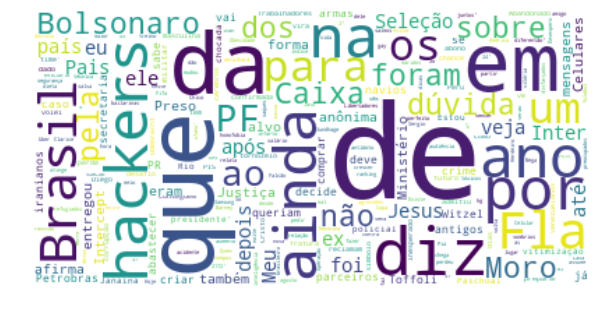

In [135]:
word_cloud_figure(news)

#### pygsheets

In [136]:
import pygsheets
from nltk.corpus import stopwords

def stop_words_gsheet():
    url = '/Users/liviaclarete/gdrive/code/functions/gdocs/googleKey_pesq7/client_secret.json'
    # reading stopwords from a google sheet
    gc = pygsheets.authorize(client_secret=url)
    # Open spreadsheet and then workseet
    sh = gc.open('stopwords_pt')
    wks = sh.sheet1
    # get the values
    stopwords_m = wks.get_all_values(returnas='matrix')
    # create a list with stopwords
    sheet_stopwords = [i[0] for i in stopwords_m]
    # loading nltk stopwords
    stop = stopwords.words('portuguese')
    stopwords_total = stop + sheet_stopwords
    return(stop)

In [137]:
# https://docs.google.com/spreadsheets/d/1GLMt63E9a-EdT-_igqXDvrLb4tf64bW_LTRLSFP2JbQ/edit#gid=1713228162

In [138]:
stwords = stop_words_gsheet()

In [139]:
stwords = stwords + ['do', 'no', 'a', 'o', 'com', 'por', 'em', 'de', 'sobre', 'diz', 'da', 'é', 'como', 'que', 'dentro', 'Após', 'diz', 'Entenda', 'dentro', 'ainda']

In [140]:
stwords[0]

'de'

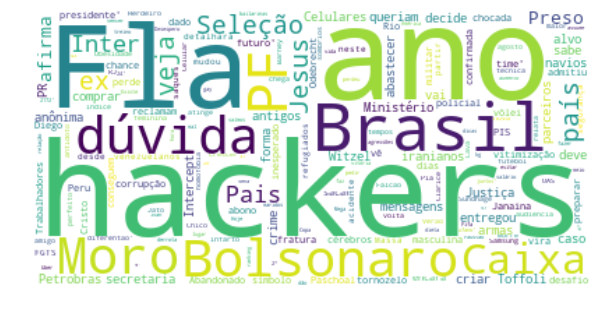

In [141]:
word_cloud_figure(news, stopwords=stwords)

### pre-processing

In [142]:
news_df = pd.DataFrame(news)

In [143]:
news_df.columns = ['news']

In [144]:
stwords = stwords

In [145]:
def pre_processing_col(col, stopwords=stwords):
    # transform the words into lower case
    col = col.apply(lambda x: x.lower())
    # removing punctuation
    col = col.str.replace('[^\w\s]', '')
    # removing numbers
    col = col.apply(
    # iterate through each item in a returns a list of words and joins the split words into a sentence again
    lambda x:' '.join([x for x in x.split() if not x.isdigit()]))
    # stopwords
    # removing stopwords
    col = col.apply(lambda x: ' '.join([x for x in x.split() if x not in stopwords]))
    return(col)

In [146]:
news_df['news_clean'] = pre_processing_col(news_df.news)

In [147]:
from textblob import TextBlob

# tokenize words from the text
def tokenization(col):
    serie = pd.Series(col.apply(lambda x:x.split()))
    return(serie)

In [148]:
news_df['token'] = tokenization(news_df.news_clean)

In [149]:
news_df.head()

,news,news_clean,token
0,Preso afirma que entregou mensagens ao Interce...,preso afirma entregou mensagens intercept form...,"[preso, afirma, entregou, mensagens, intercept..."
1,Celulares de Bolsonaro também foram alvo de ha...,celulares bolsonaro alvo hackers ministério ju...,"[celulares, bolsonaro, alvo, hackers, ministér..."
2,Hackers eram parceiros antigos de crime e quer...,hackers parceiros antigos crime queriam compra...,"[hackers, parceiros, antigos, crime, queriam, ..."
3,O que já se sabe e o que ainda é dúvida no cas...,sabe dúvida caso hackers moro,"[sabe, dúvida, caso, hackers, moro]"
4,Toffoli decide que Petrobras deve abastecer na...,toffoli decide petrobras deve abastecer navios...,"[toffoli, decide, petrobras, deve, abastecer, ..."


In [150]:
import gensim
from gensim import corpora


# Creating a term dictionary of the text corpus
dictionary = corpora.Dictionary(news_df.token)

In [152]:
# creating a Document Text Matrix with the dictionary
doc_term_matrix = [dictionary.doc2bow(i) for i in news_df['token'] ]


In [153]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=3, 
                random_state=100)

In [154]:
# Printing the topics
lda_model.print_topics()

[(0,
  '0.012*"brasil" + 0.012*"veja" + 0.012*"ano" + 0.012*"bolsonaro" + 0.012*"inter" + 0.010*"caixa" + 0.010*"após" + 0.007*"hackers" + 0.007*"fla" + 0.007*"ranking"'),
 (1,
  '0.008*"seleção" + 0.008*"moro" + 0.008*"preparar" + 0.008*"decidir" + 0.008*"masculina" + 0.008*"loreto" + 0.008*"desespero" + 0.008*"vôlei" + 0.008*"partilha" + 0.008*"eventos"'),
 (2,
  '0.015*"hackers" + 0.010*"pf" + 0.010*"jesus" + 0.010*"pais" + 0.010*"fla" + 0.007*"anos" + 0.006*"país" + 0.006*"brasil" + 0.006*"cérebros" + 0.006*"time"')]

In [155]:
import pyLDAvis
import pyLDAvis.gensim

# Downalod dictionaries from spacy -- lemmatization
# !python -m spacy download en # one time run
# !python -m spacy download pt # one time run

import matplotlib.pyplot as plt
import seaborn as sns

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/liviaclarete/.pyenv/versions/dataAnalysis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.063741 -0.039531       1        1  38.052917
0     -0.073606 -0.025515       2        1  33.464222
1      0.009865  0.065045       3        1  28.482861, topic_info=     Category      Freq          Term     Total  loglift  logprob
term                                                             
154   Default  1.000000          veja  1.000000  30.0000  30.0000
80    Default  1.000000           ano  1.000000  29.0000  29.0000
9     Default  1.000000     bolsonaro  1.000000  28.0000  28.0000
175   Default  1.000000         inter  1.000000  27.0000  27.0000
11    Default  2.000000       hackers  2.000000  26.0000  26.0000
45    Default  1.000000         caixa  1.000000  25.0000  25.0000
6     Default  1.000000            pf  1.000000  24.0000  24.0000
72    Default  1.000000         jesus  1.000000  23.0000  23.0000
184   Default  1.000000          pais  1.000000  22.0000  22.0000
62    Default  1.000000      preparar  1.000000  21.0000  21.0000
244   Default  1.000000       decidir  1.000000  20.0000  20.0000
61    Default  1.000000     masculina  1.000000  19.0000  19.0000
246   Default  1.000000        loreto  1.000000  18.0000  18.0000
178   Default  1.000000     desespero  1.000000  17.0000  17.0000
65    Default  1.000000         vôlei  1.000000  16.0000  16.0000
248   Default  1.000000      partilha  1.000000  15.0000  15.0000
214   Default  1.000000       eventos  1.000000  14.0000  14.0000
182   Default  1.000000        sergio  1.000000  13.0000  13.0000
247   Default  1.000000        mansão  1.000000  12.0000  12.0000
216   Default  1.000000            sp  1.000000  11.0000  11.0000
245   Default  1.000000        débora  1.000000  10.0000  10.0000
25    Default  1.000000        decide  1.000000   9.0000   9.0000
249   Default  1.000000           vão  1.000000   8.0000   8.0000
180   Default  1.000000  inteligência  1.000000   7.0000   7.0000
181   Default  1.000000           mal  1.000000   6.0000   6.0000
64    Default  1.000000            vê  1.000000   5.0000   5.0000
213   Default  1.000000       cultura  1.000000   4.0000   4.0000
30    Default  1.000000            pr  1.000000   3.0000   3.0000
60    Default  1.000000        futuro  1.000000   2.0000   2.0000
29    Default  1.000000     petrobras  1.000000   1.0000   1.0000
...       ...       ...           ...       ...      ...      ...
61     Topic3  0.667288     masculina  1.026725   0.8250  -4.8591
246    Topic3  0.667113        loreto  1.026730   0.8247  -4.8594
178    Topic3  0.666772     desespero  1.026747   0.8242  -4.8599
65     Topic3  0.666372         vôlei  1.026751   0.8236  -4.8605
248    Topic3  0.665912      partilha  1.026764   0.8229  -4.8612
214    Topic3  0.665842       eventos  1.026765   0.8228  -4.8613
182    Topic3  0.665170        sergio  1.026783   0.8217  -4.8623
247    Topic3  0.664900        mansão  1.026773   0.8213  -4.8627
216    Topic3  0.664217            sp  1.026804   0.8203  -4.8637
245    Topic3  0.663795        débora  1.026803   0.8196  -4.8643
25     Topic3  0.663250        decide  1.026827   0.8188  -4.8652
249    Topic3  0.663232           vão  1.026823   0.8188  -4.8652
180    Topic3  0.662777  inteligência  1.026842   0.8181  -4.8659
181    Topic3  0.662237           mal  1.026851   0.8172  -4.8667
64     Topic3  0.661197            vê  1.026875   0.8156  -4.8683
213    Topic3  0.660828       cultura  1.026883   0.8151  -4.8688
60     Topic3  0.660482        futuro  1.026885   0.8146  -4.8693
29     Topic3  0.660459     petrobras  1.026896   0.8145  -4.8694
30     Topic3  0.660429            pr  1.026900   0.8145  -4.8694
59     Topic3  0.660206        chance  1.026891   0.8141  -4.8698
215    Topic3  0.659717       maiores  1.026914   0.8134  -4.8705
197    Topic3  0.659320       entrega  1.026926   0.8128  -4.8711
26     Topic3  0.658503          deve  1.026938   0.8115 

## Scrapy flow

Terminal
* ! scrapy startproject __project_name__
* ! cd __project_name__
* scrapy genspider __spider_name__ __url_to_be_scraped__
* Go to the 'spider' folder
* scrapy genspider __spider_name__ 'www.page.com'
>* Open the spider spider_file.py
>* Modify the file
* scrapy runspider spider_file.py -o file.csv 

├── scrapy.cfg                # deploy configuration file
└── scrapy_spider             # project's Python module, you'll import your code from here
    ├── __init__.py
    ├── items.py              # project items definition file
    ├── middlewares.py        # project middlewares file
    ├── pipelines.py          # project pipeline file
    ├── settings.py           # project settings file
    └── spiders               # a directory where spiders are located
        ├── __init__.py
        └── example.py        # spider we just created

In [314]:
# -*- coding: utf-8 -*-
import scrapy

class QuotesSpiderSpider(scrapy.Spider):
    name = 'quotes_spider'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        pass

Spider paramethers

* name: identifies the Spider. It must be unique within a project

* start_urls: The list of the feed URLs, the spider would start by crawling the feed URLs.

* allowed_domains: This setting is useful for broad crawls, if the domain of the URL is not in this setting, then the URL would be ignored.

* parse: a method that will be called to handle the response downloaded for each of the requests made.

In [316]:
import scrapy

class QuotesSpiderSpider(scrapy.Spider):
    name = 'quotes_spider'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        quotes = response.xpath("//div[@class='quote']//span[@class='text']/text()").extract()
        yield {'quotes': quotes}

In [328]:
path = '/Users/liviaclarete/Documents/june2019-ft/quotes/quotes/spiders/' 

In [336]:
quotes_1_path = path + 'quotes.csv'

In [337]:
quotes = pd.read_csv(quotes_1, sep=',')

In [338]:
quotes

,quotes
0,“The world as we have created it is a process ...


In [348]:
class QuotesSpiderSpider(scrapy.Spider):
    name = 'quotes_spider'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        quotes = response.xpath("//div[@class='quote']")
        for quote in quotes:
            text = quote.xpath(
                ".//span[@class='text']/text()").extract_first()
            author = quote.xpath(
                ".//small//text()").extract_first()
            yield {'quote': text, "author": author}

In [344]:
quotes_2_path = path + 'quotes_2.csv'

In [345]:
quotes2 = pd.read_csv(quotes_2_path)

In [347]:
quotes2

,quote,author
0,“The world as we have created it is a process ...,Albert Einstein
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling
2,“There are only two ways to live your life. On...,Albert Einstein
3,"“The person, be it gentleman or lady, who has ...",Jane Austen
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe
5,“Try not to become a man of success. Rather be...,Albert Einstein
6,“It is better to be hated for what you are tha...,André Gide
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison
8,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt
9,"“A day without sunshine is like, you know, nig...",Steve Martin


In [349]:
class QuotesSpiderSpider(scrapy.Spider):
    name = 'quotes_spider'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        quotes = response.xpath("//div[@class='quote']")
        for quote in quotes:
            text = quote.xpath(
                ".//span[@class='text']/text()").extract_first()
            author = quote.xpath(
                ".//small//text()").extract_first()
            yield {'quote': text, "author": author}

        next_page_url = response.xpath("//li[@class='next']//a/@href").extract_first()
        if next_page_url:
            absolute_next_page_url = response.urljoin(next_page_url)
            yield scrapy.Request(absolute_next_page_url)

In [350]:
quotes_3_path = path + 'quotes_3.csv'

In [351]:
quotes3 = pd.read_csv(quotes_3_path)

In [31]:
quotes3.head()

NameError: name 'quotes3' is not defined

In [121]:
teste = [[['1st'], ['ExidiuM'], [], ['Brunei'], ['/team/9527/exidium']], [['2nd'], ['Goodfellas'], [], ['Brunei'], ['/team/8618/goodfellas']], [['3-4th'], ['HIT AND RUN'], [], ['Brunei'], ['/team/9528/hit-and-run']], [['3-4th'], ['XDM'], [], ['Brunei'], ['/team/9529/xdm']]]

In [122]:
import numpy as np

In [123]:
st = list(np.ravel([i[0] for i in teste]))

In [124]:
st

['1st', '2nd', '3-4th', '3-4th']